# Building Mapping

## Dataset
Input data are RGB satellite images.

In [17]:
import os
import glob # selecting the number of files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image 

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

## Data Preprocessing

In [2]:
train_X = sorted(glob.glob("train/*_image.tif"))
train_y = sorted(glob.glob("train/*_label.tif"))
test_X = sorted(glob.glob("test/*_image.tif"))
test_y = sorted(glob.glob("test/*_label.tif"))

In [3]:
# converting training images to numpy arrays
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_X, train_y)):
    img = Image.open(img)
    train_xx[i] = np.array(img)
    mask = Image.open(mask)
    train_yy[i] = np.array(mask).reshape(128, 128, 1)

In [4]:
# converting test images to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_X, test_y)):
    img = Image.open(img)
    test_xx[i] = np.array(img)
    mask = Image.open(mask)
    test_yy[i] = np.array(mask).reshape(128, 128, 1)

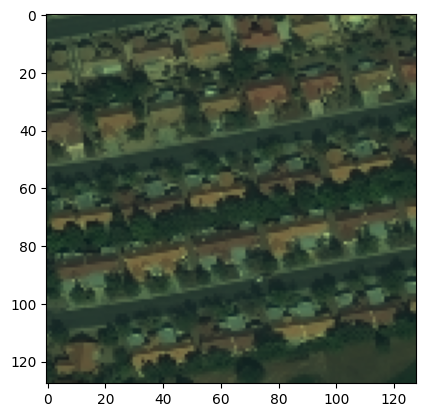

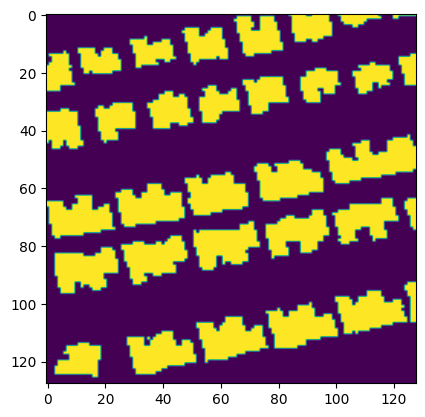

In [5]:
plt.imshow(train_xx[20, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[20, :, :, 0].astype('uint8'))
plt.show()

In [6]:
# save to numpy format
train_xx.shape

(70, 128, 128, 3)

In [7]:
np.save('train_xx.npy', train_xx)
np.save('test_xx.npy', test_xx)
np.save('train_yy.npy', train_yy)
np.save('test_yy.npy', test_yy)

## U-Net Model

In [21]:
x_input = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_input)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2, 2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

In [22]:
'''Use 1 by 1 convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)

# here we will use sigmoid activation because output values are either 0 or 1
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

In [23]:
model = Model(inputs=x_input, outputs=x_out)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      9,248 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_9[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32, 32,    │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_10[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16, 16,    │          0 │ conv2d_17[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 16, 16,    │     36,928 │ conv2d_18[0][0] 

 Total params: 409,281 (1.56 MB)

 Trainable params: 409,281 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [24]:
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100,
                    batch_size=10,
                    verbose=1)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 981ms/step - loss: 0.2671 - val_loss: 0.2193
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 955ms/step - loss: 0.2068 - val_loss: 0.1933
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 924ms/step - loss: 0.1894 - val_loss: 0.1691
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 940ms/step - loss: 0.1720 - val_loss: 0.1492
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 928ms/step - loss: 0.1571 - val_loss: 0.1357
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 920ms/step - loss: 0.1548 - val_loss: 0.1427
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 913ms/step - loss: 0.1563 - val_loss: 0.1414
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 895ms/step - loss: 0.1550 - val_loss: 0.1361
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 914ms/step - loss: 0.1446 - val_loss: 0.1270
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step - loss: 0.1380 - val_loss: 0.1211
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 910ms/step - loss: 0.1282 - val_loss: 0.1186
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 930ms/step - loss: 0.

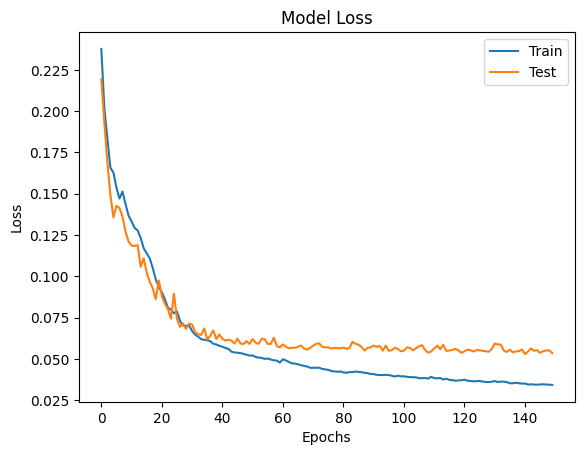

In [25]:
# plotting model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Prediction


In [26]:
threshold = 0.5

# prediction of the putput
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype('uint8')
print(pred_test.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(30, 128, 128, 1)


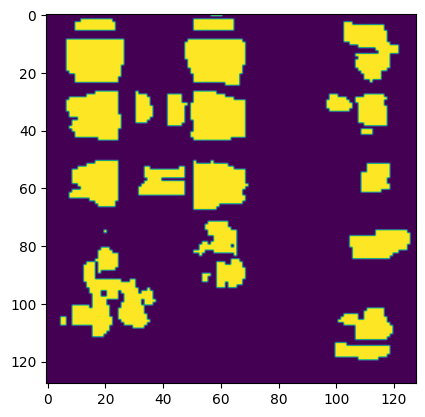

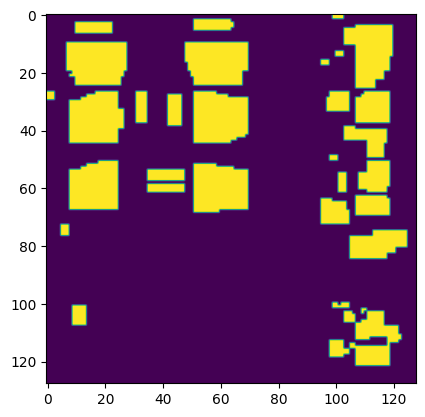

In [27]:
# compare predicted and actual y values
plt.imshow(pred_test[10, :, :, 0])
plt.show()
plt.imshow(test_yy[10, :, :, 0])
plt.show()

## Convert numpy to array image

In [18]:
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel==3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))
        
        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

In [19]:
# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('train_xx.npy').astype('float32')
y_train= np.load('train_yy.npy').astype('float32')
x_test = np.load('test_xx.npy').astype('float32')
y_test = np.load('test_yy.npy').astype('float32') 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


In [20]:
convert_numpy_array_to_img(x_train, 'train')
convert_numpy_array_to_img(y_train, 'train', channel=1)

convert_numpy_array_to_img(x_test, 'test')
convert_numpy_array_to_img(y_test, 'test', channel=1)